SLaM (Source, Light and Mass): Mass Total + Subhalo NFW + Source Parametric
===========================================================================

Using 1 source pipeline, a mass pipeline and a subhalo pipeline this SLaM runner fits `Imaging` of a strong lens
system, where in the final model:

 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal` and `ExternalShear`.
 - A dark matter subhalo`s within the lens galaxy is a `SphericalNFWMCRLudLow`.
 - The source galaxy is an `EllipticalSersic`.

This runner uses the SLaM pipelines:

 `slam/no_lens_light/pipelines/source__mass_sie__source_parametric.py`.
 `slam/no_lens_light/pipelines/mass__mass_power_law__source.py`.
 `slam/no_lens_light/pipelines/subhalo__mass__subhalo_nfw__source.py`.

Check them out for a detailed description of the analysis!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

dataset_name = "mass_sie__subhalo_nfw__source_sersic"
pixel_scales = 0.05

dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Using the dataset path, load the data (image, noise-map, PSF) as an `Imaging` object from .fits files.

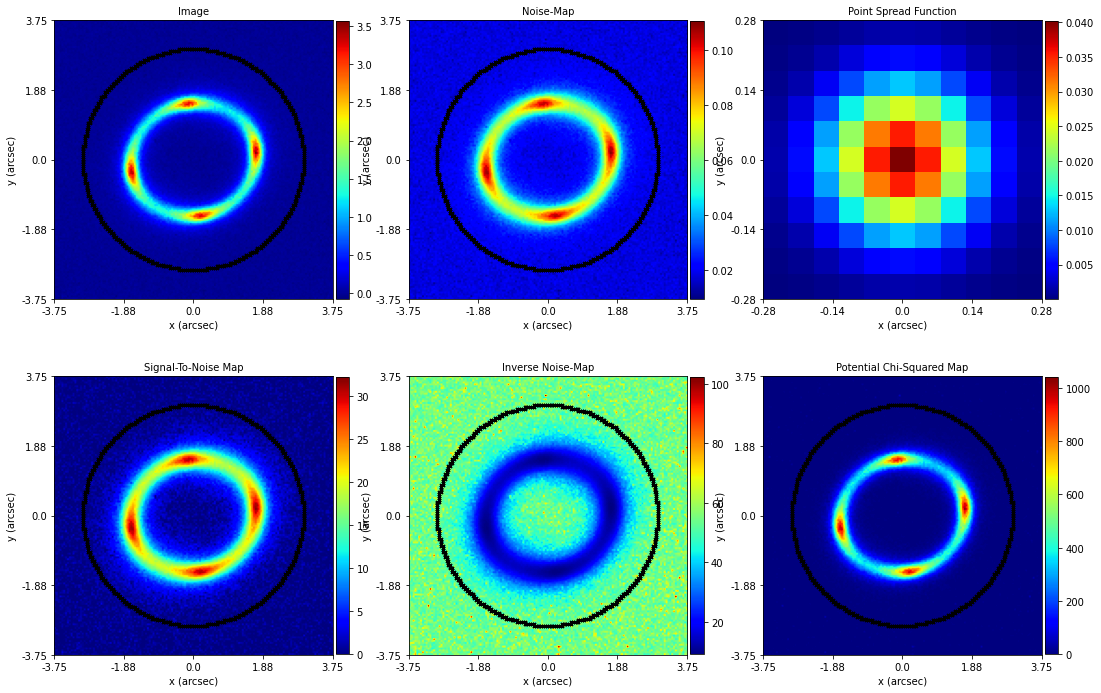

In [2]:
imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=pixel_scales,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Settings__

The `SettingsPhaseImaging` describe how the model is fitted to the data in the log likelihood function.

These settings are used and described throughout the `autolens_workspace/notebooks/imaging/modeling` example scripts, with a 
complete description of all settings given in `autolens_workspace/notebooks/imaging/modeling/customize/settings.py`.

The settings chosen here are applied to all searches in the pipeline.

In [3]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__PIPELINE SETUP__

Pipelines use the `SetupPipeline` object to customize the analysis performed by the pipeline,
for example if a shear was included in the mass model and the model used for the source galaxy.

SLaM pipelines break the analysis down into multiple pipelines which focus on modeling a specific aspect of the strong 
lens, first the Source, then the (lens) Light and finally the Mass. Each of these pipelines has it own setup object 
which is equivalent to the `SetupPipeline` object, customizing the analysis in that pipeline. Each pipeline therefore
has its own `SetupMass` and `SetupSourceParametric` object.

The `Setup` used in earlier pipelines determine the model used in later pipelines. For example, if the `Source` 
pipeline is given an `EllipticalSersic` parametric profile, then this `LightProfile` will be used in the subsequent 
`SLaMPipelineMass`.

The `Setup` again tags the path structure of every pipeline in a unique way, such than combinations of different
SLaM pipelines can be used to fit lenses with different models. If the earlier pipelines are identical (e.g. they use
the same `SLaMPipelineSource`. they will reuse those results before branching off to fit different models in the `SLaMPipelineLightParametric` 
and / or `SLaMPipelineMass` pipelines. 

__HYPER SETUP__

The `SetupHyper` determines which hyper-mode features are used during the model-fit and is used identically to the
hyper pipeline examples.

The `SetupHyper` object has a new input available, `hyper_fixed_after_source`, which fixes the hyper-parameters to
the values computed by the hyper-phase at the end of the Source pipeline. By fixing the hyper-parameter values in the
_SLaMPipelineLight_ and `SLaMPipelineMass` pipelines, model comparison can be performed in a consistent fashion.

In [4]:
hyper = al.SetupHyper(
    hyper_galaxies_lens=False,
    hyper_galaxies_source=False,
    hyper_image_sky=None,
    hyper_background_noise=None,
)

__SLaMPipelineSourceParametric__

The parametric source pipeline aims to initialize a robust model for the source galaxy using `LightProfile` objects. 

 Source: This parametric source model is used by the SLaM Mass pipeline that follows, and thus sets the complexity of 
 the parametric source model of the overall fit. 
 
 For this runner the `SetupSourceParametric` customizes: 
 
 - That the bulge of the source `Galaxy` is fitted using an `EllipticalSersic`.
 - There is has no over `LightProfile` components (e.g. a disk, envelope)_.

In [5]:
setup_source = al.SetupSourceParametric(
    bulge_prior_model=al.lp.EllipticalSersic,
    disk_prior_model=None,
    envelope_prior_model=None,
)

 Mass: The `MassProfile` used to model the lens galaxy's mass. This is changed in the SLaM Mass pipeline that follows.
 
 Our experience with lens modeling has shown the `EllipticalIsothermal` profile is the simpliest model to fit that 
 provide a good fit to the majority of strong lenses.
 
 For this runner the `SetupMassProfile` customizes:

 - That the mass of the lens `Galaxy` is fitted using an `EllipticalIsothermal`.
 - That there is not `ExternalShear` in the mass model.
 - That the mass profile centre is (0.0, 0.0) (this assumption will be relaxed in the SLaM Mass Pipeline.

In [6]:
setup_mass = al.SetupMassTotal(
    mass_prior_model=al.mp.EllipticalIsothermal, with_shear=True, mass_centre=(0.0, 0.0)
)

We combine the `SetupSource` and `SetupMass` above to create the SLaM parametric Source Pipeline.

In [7]:
pipeline_source_parametric = al.SLaMPipelineSourceParametric(
    setup_mass=setup_mass, setup_source=setup_source
)

__SLaMPipelineMassTotal__

The `SLaMPipelineMassTotal` pipeline fits the model for the lens galaxy's total mass distribution. 

A full description of all options can be found ? and ?.

The model used to represent the lens galaxy's mass is input into `SLaMPipelineMass` and this runner uses an 
`EllipticalIsothermal` in this example.

For this runner the `SLaMPipelineMass` customizes:

 - The `MassProfile` fitted by the pipeline.
 - If there is an `ExternalShear` in the mass model or not.

In [8]:
setup_mass = al.SetupMassTotal(
    mass_prior_model=al.mp.EllipticalIsothermal, with_shear=True
)

pipeline_mass = al.SLaMPipelineMass(setup_mass=setup_mass)

__SetupSubhalo__

The final pipeline fits the lens and source model including a `SphericalNFW` subhalo, using a grid-search of non-linear
searches. 

A full description of all options can be found ? and ?.

The models used to represent the lens galaxy's mass and the source are those used in the previous pipelines.

For this runner the `SetupSubhalo` customizes:

 - If the parameteric source galaxy is treated as a model (all free parameters) or instance (all fixed) during the 
   subhalo detection grid search.
 - The NxN size of the grid-search.

In [9]:
setup_subhalo = al.SetupSubhalo(
   source_is_model=False, number_of_steps=5
)

__SLaM__

We combine all of the above `SLaM` pipelines into a `SLaM` object.

The `SLaM` object contains a number of methods used in the make_pipeline functions which are used to compose the model 
based on the input values. It also handles pipeline tagging and path structure.

In [10]:
slam = al.SLaM(
    path_prefix=path.join("imaging", "slam", "no_lens_light", dataset_name),
    setup_hyper=hyper,
    pipeline_source_parametric=pipeline_source_parametric,
    pipeline_mass=pipeline_mass,
    setup_subhalo=setup_subhalo,
)

__PIPELINE CREATION__

We import and make pipelines as per usual, albeit we'll now be doing this for multiple pipelines!

We then run each pipeline, passing the results of previous pipelines to subsequent pipelines.

In [11]:
from pipelines import source__parametric
from pipelines import mass__total
from pipelines import subhalo

source__parametric = source__parametric.make_pipeline(slam=slam, settings=settings)
source_results = source__parametric.run(dataset=imaging, mask=mask)

mass__total = mass__total.make_pipeline(
    slam=slam, settings=settings, source_results=source_results
)
mass_results = mass__total.run(dataset=imaging, mask=mask)

subhalo = subhalo.make_pipeline_single_plane(
    slam=slam, settings=settings, mass_results=mass_results
)
subhalo.run(dataset=imaging, mask=mask)

INFO:autofit.tools.pipeline:Running Phase phase[1]_mass[total]_source[parametric] (Number 0)
INFO:root:phase[1]_mass[total]_source[parametric] already completed, skipping non-linear search.
INFO:autofit.tools.pipeline:Running Phase phase[1]_mass[total]_source (Number 0)
INFO:root:phase[1]_mass[total]_source already completed, skipping non-linear search.
INFO:autofit.tools.pipeline:Running Phase phase[1]_mass[total_refine] (Number 0)
INFO:root:phase[1]_mass[total_refine] already completed, skipping non-linear search.
INFO:autofit.tools.pipeline:Running Phase phase[2]_mass[total]_source_subhalo[search_lens_plane] (Number 1)
INFO:root:phase[2]_mass[total]_source_subhalo[search_lens_plane]/settings__imaging[grid_sub_2]__lens[pos_off]/dynesty_static[nlive_50__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_rwalk_walks_5_facc_0.2]/galaxies_subhalo_mass_centre_0_-3.00_-1.80_galaxies_subhalo_mass_centre_1_-3.00_-1.80 already completed, skipping non-linear search.
INFO:root:phase[2]_

Finish.